<a href="https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIP Explainability**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("../")
sys.path.append("../CLIP_explainability/Transformer-MM-Explainability/")

# **CLIP**

In [3]:
from os.path import join
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
import warnings
from torchmetrics import JaccardIndex

warnings.filterwarnings('ignore')

In [4]:
from CLIP_explainability.utils import interpret, show_img_heatmap, show_txt_heatmap, color
from clip_grounding.utils.paths import REPO_PATH
from clip_grounding.datasets.png import PNG
from clip_grounding.utils.image import pad_to_square
from clip_grounding.utils.visualize import show_grid_of_images

In [5]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
}

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

## Run on sample image-text pair

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with eye glasses


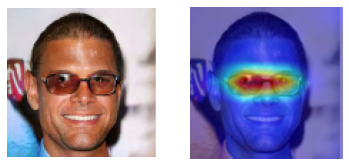

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with white teeth


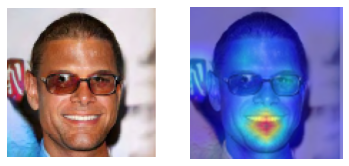

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a man with a nose


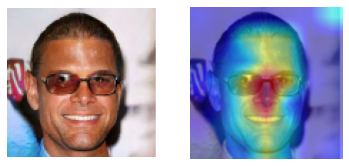

In [7]:
def show_cam(mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap
    cam = cam / np.max(cam)
    return cam


def interpret_and_generate(model, img, texts, orig_image, return_outputs=False):
    text = clip.tokenize(texts).to(device)
    R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
    batch_size = text.shape[0]
    
    outputs = []
    for i in range(batch_size):
        text_scores = show_txt_heatmap(texts[i], text[i], R_text[i])
        image_relevance = show_img_heatmap(R_image[i], img, orig_image=orig_image, device=device)
        plt.show()
        outputs.append({"text_scores": text_scores, "image_relevance": image_relevance})
    
    if return_outputs:
        return outputs
        


texts = ["a man with eyeglasses", "a man with white teeth", "a man with a nose"]
img_path = join(REPO_PATH, "CLIP_explainability", "Transformer-MM-Explainability", "CLIP/glasses.png")
pil_image = Image.open(img_path)
img = preprocess(pil_image).unsqueeze(0).to(device)
outputs = interpret_and_generate(model, img, texts, pil_image, return_outputs=True)

In [8]:
len(outputs)

3

In [9]:
outputs[0].keys()

dict_keys(['text_scores', 'image_relevance'])

In [10]:
outputs[0]["text_scores"].shape

torch.Size([5])

In [11]:
outputs[0]["image_relevance"].shape, outputs[0]["image_relevance"].min(), outputs[0]["image_relevance"].max()

((224, 224), 0.0, 1.0)

## Run on `Panoptic Narrative Grounding` benchmark

In [12]:
dataset = PNG(dataset_root=join(REPO_PATH, "data", "panoptic_narrative_grounding"), split="val2017")

In [13]:
len(dataset)

8573

In [14]:
def process_entry_text_to_image(entry):
    image = entry['image']
    text_mask = entry['text_mask']
    text = entry['text']
    orig_image = pad_to_square(image)
    
    img = preprocess(orig_image).unsqueeze(0).to(device)
    text_index = text_mask.argmax()
    texts = [text[text_index]]
    
    return img, texts, orig_image

#### Run on one sample from the dataset

In [45]:
idx = 8
instance = dataset[idx]

**Run text-to-image test**

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,person


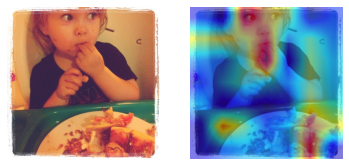

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,food item


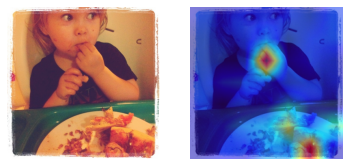

In [46]:
for entry in instance:
    test_img, test_texts, orig_image = process_entry_text_to_image(entry)
    outputs = interpret_and_generate(model, test_img, test_texts, orig_image, return_outputs=True)

**Compute metric (IoU) between relevance and ground truth segmentation map**

In [47]:
jaccard = JaccardIndex(num_classes=2)
jaccard = jaccard.to(device)

In [48]:
def preprocess_ground_truth_mask(mask, resize_shape):
    mask = Image.fromarray(mask.astype(np.uint8) * 255)
    mask = pad_to_square(mask, color=0)
    mask = mask.resize(resize_shape)
    mask = np.asarray(mask) / 255.
    return mask


# sample
test_relevance_map = outputs[0]["image_relevance"]

test_ground_truth_mask = entry["image_mask"]
test_ground_truth_mask = preprocess_ground_truth_mask(test_ground_truth_mask, test_relevance_map.shape)

In [49]:
alpha = 0.3
overlaid = alpha * test_ground_truth_mask + (1 - alpha) * test_relevance_map

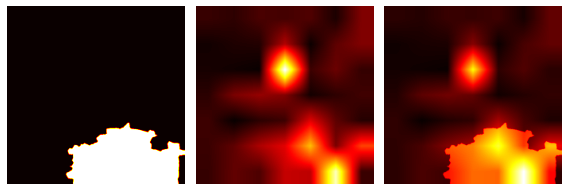

In [50]:
show_grid_of_images([test_ground_truth_mask, test_relevance_map, overlaid], cmap="hot")

In [51]:
iou = jaccard(
    torch.from_numpy(test_relevance_map).to(device),
    torch.from_numpy(test_ground_truth_mask.astype(np.uint8)).to(device),
)
iou = iou.item()

In [52]:
iou

0.5184481143951416

**Run image-to-text test**

In [23]:
def process_entry_image_to_text(entry):
    mask = np.repeat(np.expand_dims(entry['image_mask'], -1), 3, axis=-1)
    masked_image = (mask * np.asarray(entry['image'])).astype(np.uint8)
    masked_image = Image.fromarray(masked_image)
    texts = [' '.join(entry['text'])]
    orig_image = pad_to_square(masked_image)
    img = preprocess(orig_image).unsqueeze(0).to(device)
    
    return img, texts, orig_image

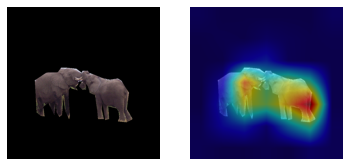

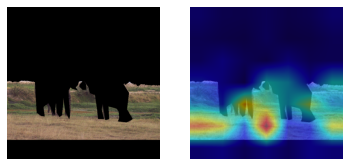

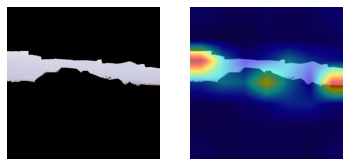

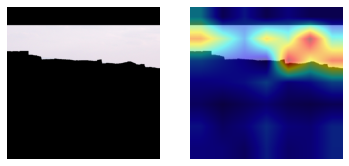

In [24]:
for entry in instance:
    img, texts, orig_image = process_entry_image_to_text(entry)
    outputs = interpret_and_generate(model, img, texts, orig_image, return_outputs=True)